In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import cv2

In [2]:
IMAGE_SIZE = 512 * 512

In [3]:
def read_cv2(path: str):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    max_pixel_value = 255.0
    return 20 * np.log10(max_pixel_value / np.sqrt(mse))


def get_bpp(path: str):
    return os.path.getsize(path) * 8 / IMAGE_SIZE


def find_similar_bpp(name: str, bpp: float):
    tmp_path = "../assets/images/tmp.jpg"
    best_qf = 1
    best_bpp = float("inf")
    for qf in range(1, 100, 1):
        img = read_cv2(f"../assets/images/{name}.png")
        cv2.imwrite(tmp_path, img, [cv2.IMWRITE_JPEG_QUALITY, qf])
        cur_bpp = get_bpp(tmp_path)
        if abs(cur_bpp - bpp) < abs(best_bpp - bpp):
            best_qf = qf
            best_bpp = cur_bpp
    
    os.remove(tmp_path)
    return best_qf

In [4]:
from collections import defaultdict

result = defaultdict(dict)

for b in ["B=2", "B=8"]:
    for name in ["lena", "baboon", "peppers"]:
        compressed_bpp = get_bpp(f"../assets/compressed/{b}/{name}.bin")
        jpeg_qf = find_similar_bpp(name, compressed_bpp)
        result[b][name] = (jpeg_qf, compressed_bpp)
        
result

defaultdict(dict,
            {'B=2': {'lena': (35, 0.604644775390625),
              'baboon': (12, 0.6026611328125),
              'peppers': (33, 0.61651611328125)},
             'B=8': {'lena': (90, 2.275726318359375),
              'baboon': (72, 2.2744140625),
              'peppers': (89, 2.28790283203125)}})

In [6]:
for b, names in result.items():
    os.makedirs(f"../assets/jpegs/{b}", exist_ok=True)
    for name, (qf, _) in names.items():
        img = read_cv2(f"../assets/images/{name}.png")
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(f"../assets/jpegs/{b}/{name}.jpg", img, [cv2.IMWRITE_JPEG_QUALITY, qf])

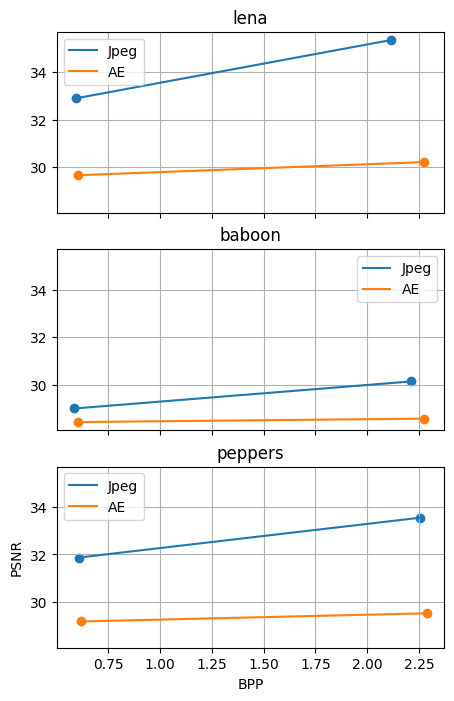

In [25]:
_, axs = plt.subplots(3, 1, figsize=(5, 8), sharex=True, sharey=True)


plt.xlabel("BPP")
plt.ylabel("PSNR")

for i, name in enumerate(["lena", "baboon", "peppers"]):
    original = Image.open(f"../assets/images/{name}.png")
    
    psnr_jpeg = []
    bpp_jpeg = []
    psnr_ae = []
    bpp_ae = []
    
    for b in ["B=2", "B=8"]:
        jpeg_path = f"../assets/jpegs/{b}/{name}.jpg"
        ae_path = f"../assets/decompressed/{b}/{name}.png"
        
        jpeg = Image.open(jpeg_path)
        ae = Image.open(ae_path)
        
        psnr_jpeg.append(psnr(np.asarray(original), np.asarray(jpeg)))
        psnr_ae.append(psnr(np.asarray(original), np.asarray(ae)))
        
        bpp_jpeg.append(get_bpp(jpeg_path))
        bpp_ae.append(get_bpp(f"../assets/compressed/{b}/{name}.bin"))
        
    ax = axs[i]
    ax.grid()
    ax.set_title(name)
    ax.scatter(bpp_jpeg, psnr_jpeg)
    ax.scatter(bpp_ae, psnr_ae)
    ax.plot(bpp_jpeg, psnr_jpeg, label="Jpeg")
    ax.plot(bpp_ae, psnr_ae, label="AE")
    ax.legend()

plt.savefig("../assets/graphs/psnr-bpp.png")